# Table of Contents
1. Heatmaps
> 1.1 Test metrics heatmaps    
> 1.2 TSS heatmaps    
> 1.3 F1 heatmaps    
2. Precision-recall curves
> 2.1 PRCs per model    
> 2.2 PRCs for smoothed predictions   
    
## 1. Heatmaps

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import copy
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def get_test_metrics(prefixes, dset, order, input_dir):
    all_test_metrics = []
    for i, prefix in enumerate(prefixes):
        file_path = os.path.join(input_dir, f"{prefix}_test_metrics.log")
        header = np.loadtxt(file_path, max_rows=1, dtype=str)
        idx = np.where(header == f"{dset}_avg_val_accuracy")[0]
        if len(idx) == 0:
            continue
        metrics = np.loadtxt(file_path, skiprows=1, usecols=idx)
        labels = np.loadtxt(file_path, skiprows=1, usecols=0, dtype=str)
        
        # reorder the test metrics to the order of the labels in 'order'
        test_metrics = []
        for species in order:
            if species in labels:
                idx = np.where(labels==species)[0]
                test_metrics.append(metrics[idx])
            else:
                test_metrics.append(np.array([np.nan]))
        all_test_metrics.append(np.concatenate(test_metrics))
    return np.stack(all_test_metrics, axis=-1)

In [3]:
def get_test_metrics2(prefixes, dset, order, input_dir):
    all_test_metrics = []
    for i, prefix in enumerate(prefixes):
        file_path = os.path.join(input_dir, f"{prefix}_test_metrics.log")
        header = np.loadtxt(file_path, max_rows=1, dtype=str)
        idx = np.where(header == f"{dset}_avg_val_accuracy")[0]
        if len(idx) == 0:
            continue
        metrics = np.loadtxt(file_path, skiprows=1, usecols=idx)
        labels = np.loadtxt(file_path, skiprows=1, usecols=0, dtype=str)
        
        # reorder the test metrics to the order of the labels in 'order'
        test_metrics = []
        for species in order:
            # change, because IS models used validation files with other names, i.e. Athaliana_val
            if "val" in labels[0]:
                species = f"{species}_val"
            if species in labels:
                idx = np.where(labels==species)[0]
                test_metrics.append(metrics[idx])
            else:
                test_metrics.append(np.array([np.nan]))
        all_test_metrics.append(np.concatenate(test_metrics))
    return np.stack(all_test_metrics, axis=-1)

In [4]:
def plot_test_metrics(data, cmap, xlabels, ylabels, figsize=(14, 10), dpi=100, yaxis=True, square=True, divider=10):
    fig, ax = plt.subplots(1, sharex=True, figsize=figsize, dpi=dpi)
    cmap = copy.copy(mpl.colormaps[cmap])
    cmap.set_bad(color="silver")  # NaN values are represented by siver/grey
    im = sns.heatmap(ax=ax, data=data, cmap=cmap, vmin=0., vmax=1., square=square,
                     cbar_kws={"ticks":np.arange(0., 1.1, 0.1), "pad": 0.05, "aspect":20, "shrink": 0.7})
    ax.set_xticks(np.arange(len(xlabels))+0.5, labels=xlabels, fontname="Times New Roman")
    ax.tick_params(axis="x", labelrotation=90, labelsize=16)
    
    if yaxis:
        ax.set_yticks(np.arange(len(ylabels))+0.5, labels=ylabels, fontname="Times New Roman")
        ax.tick_params(axis="y", labelrotation=0, labelsize=16)
    else:
        ax.get_yaxis().set_visible(False)
    
    b, t = plt.ylim()
    ax.vlines(x = divider, ymin = b, ymax = t, colors = 'white', lw = 4)
    
    # cbar
    cbar = im.collections[0].colorbar
    cbar.ax.set_ylabel("Pearson's r",rotation=-90, va="bottom", size=17, fontname="Times New Roman")
    cbar.ax.tick_params(labelsize=14, color="black", direction="out", length=5., pad=0.5, width=1.5)
    for l in cbar.ax.yaxis.get_ticklabels():
        l.set_family("Times New Roman")

    plt.setp(ax.spines.values(), color=None)
    plt.show()

### 1.1 Test metrics heatmaps
The species order below corresponds to the order of species given by the NCBI's taxonomy common tree application. The Pearson's correlation per species and model are plotted. The heatmap is divided into ATAC-seq (first block) and ChIP-seq (second block).

In [5]:
species = ["Bnatans", "Creinhardtii", "Mpolymorpha", "Spolyrhiza", "Enindensis", "Othomaeum", "Bdistachyon", "Zmays",
           "Sbicolor", "Sitalica", "Pmiliaceum", "Obrachyantha", "Osativa", "Sindicum", "Slycopersicum", "Mtruncatula",
           "Gmax", "Ppersica", "Pbretschneideri", "Mdomestica", "Athaliana", "Boleracea", "Brapa", "Bnapus", "Achinensis"]
# order of taxonomy tree

In [6]:
models = ["U-Net", "Hybrid", "BiHybrid", "BiHybrid_02", "BiHybrid_03.1","BiHybrid_03.2",
          "BiHybrid_03.1*", "BiHybrid_04*", "Combined*", "Combined_02*", "BiHybrid_05*", "Combined*", "Combined_02*"]

In [7]:
atac_data = get_test_metrics(["U_net_rep3", "Hybrid_rep2", "BiHybrid_rep1", "BiHybrid_02_rep1", "BiHybrid_03.1_rep2",
                              "BiHybrid_03.2_rep2","BiHybrid_03.1_rep2_filtered", "BiHybrid_04_rep3", "Combined_rep3",
                              "Combined_02_rep2"],
                             "atacseq", species, "results")
chip_data = get_test_metrics(["BiHybrid_05_rep1", "Combined_rep3", "Combined_02_rep2"], "h3k4me3", species, "results")
total_data = np.concatenate([atac_data, chip_data], axis=1)

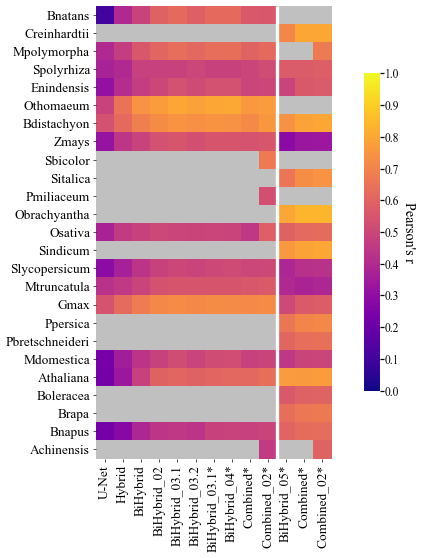

In [8]:
# with y labels
plot_test_metrics(total_data, "plasma", models, species, dpi=60)

In [9]:
atac_data = get_test_metrics2(["Combined_02_rep2", "leave_one_out", "IS_10", "IS_20"],
                             "atacseq", species, "results")
chip_data = get_test_metrics2(["Combined_02_rep2", "leave_one_out", "IS_10", "IS_20"], "h3k4me3", species, "results")
total_data = np.concatenate([atac_data, chip_data], axis=1)
models = ["Combined_02", "L1O", "IS_10", "IS_20",
          "Combined_02", "L1O", "IS_10", "IS_20"]

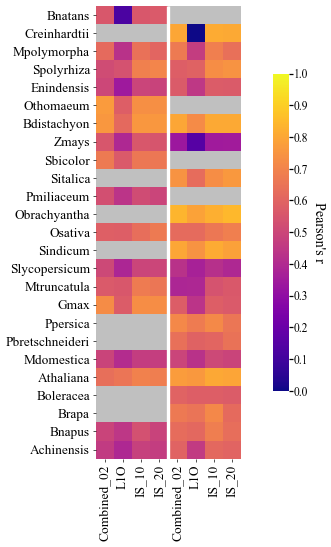

In [10]:
# with y labels
plot_test_metrics(total_data, "plasma", models, species, dpi=60, divider=4)

### 1.2 TSS heatmaps
The TSS heatmaps were created for the hold-out test set, the genomes of _A. thaliana_ and _O. sativa_.

In [11]:
def plot_heatmap(data, cmap, xlabels, ylabels, figsize=(14, 10), dpi=100, yaxis=True, square=True, fsize=19):
    fig, ax = plt.subplots(1, sharex=True, figsize=figsize, dpi=dpi)
    cmap = copy.copy(mpl.colormaps[cmap])
    cmap.set_bad(color="silver")  # NaN values are represented by siver/grey
    im = sns.heatmap(ax=ax, data=data, cmap=cmap, vmin=0., vmax=1., square=square, annot=True, fmt=".4f",
                     cbar_kws={"ticks":np.arange(0., 1.1, 0.1), "pad": 0.05, "aspect":20, "shrink": 0.7},
                     annot_kws={"family":"Times New Roman", "color": "black", "fontsize": fsize-2})  # 'fontsize': 12, 
    ax.set_xticks(np.arange(len(xlabels))+0.5, labels=xlabels, fontname="Times New Roman")
    ax.tick_params(axis="x", labelrotation=90, labelsize=fsize)
    
    ax.set_yticks(np.arange(len(ylabels))+0.5, labels=ylabels, fontname="Times New Roman", style="italic")
    ax.tick_params(axis="y", labelrotation=0, labelsize=fsize)
    
    ax.yaxis.tick_left()
    ax.xaxis.tick_bottom()
    
    # cbar
    cbar = im.collections[0].colorbar
    cbar.ax.set_ylabel("Pearson's r",rotation=-90, va="bottom", size=fsize+1, fontname="Times New Roman")
    cbar.ax.tick_params(labelsize=fsize-2, color="black", direction="out", length=5., pad=0.5, width=1.5)
    for l in cbar.ax.yaxis.get_ticklabels():
        l.set_family("Times New Roman")

    plt.setp(ax.spines.values(), color=None)
    plt.show()

In [12]:
atac_data1 = np.loadtxt("../paper/predictions/Athaliana_atacseq_bl_pearson.csv", skiprows=1, usecols=1)
atac_data2 = np.loadtxt("../paper/predictions/Osativa_atacseq_bl_pearson.csv", skiprows=1, usecols=1)
atac_data = np.stack([atac_data1[1:], atac_data2[1:]])
print(atac_data.shape)

(2, 9)


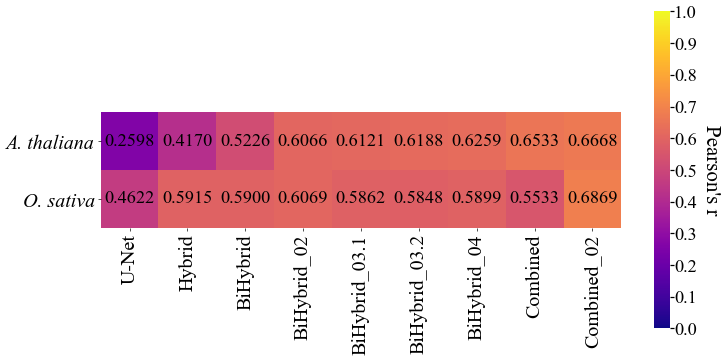

In [13]:
plot_heatmap(atac_data, "plasma",
             ["U-Net", "Hybrid", "BiHybrid", "BiHybrid_02", "BiHybrid_03.1", "BiHybrid_03.2",
              "BiHybrid_04", "Combined", "Combined_02"], ["A. thaliana", "O. sativa"],
             figsize=(14, 10), dpi=60, yaxis=True, square=True, fsize=24)

In [14]:
chip_data1 = np.loadtxt("../paper/predictions/Athaliana_h3k4me3_bl_pearson.csv", skiprows=1, usecols=1)
chip_data2 = np.loadtxt("../paper/predictions/Osativa_h3k4me3_bl_pearson.csv", skiprows=1, usecols=1)
chip_data = np.stack([chip_data1[1:], chip_data2[1:]])
print(chip_data.shape)
n = np.array([[np.nan, np.nan, np.nan, np.nan, np.nan, np.nan], [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]])
print(n.shape)
chip_data = np.concatenate([chip_data, n], axis=1)
print(chip_data.shape)

(2, 3)
(2, 6)
(2, 9)


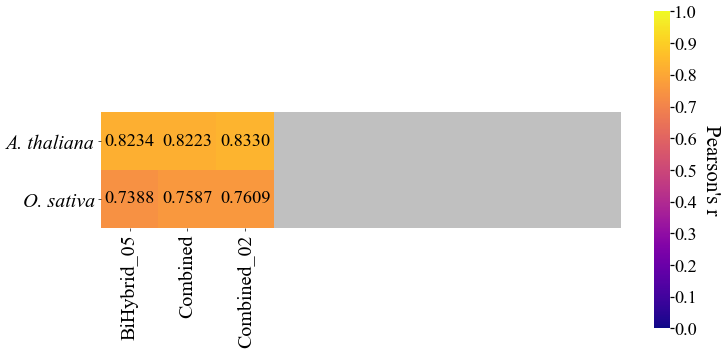

In [15]:
plot_heatmap(chip_data, "plasma",
             ["BiHybrid_05", "Combined", "Combined_02"], ["A. thaliana", "O. sativa"],
             figsize=(14, 10), dpi=60, yaxis=True, square=True, fsize=24)

In [16]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(cmap_name, header, dpi=100, fsize=18, figsize=(6, 0.3)):
    fig, ax = plt.subplots(nrows=1, figsize=figsize, dpi=dpi)
    ax.set_title(header, fontsize=fsize+1, fontname="Times New Roman")

    ax.imshow(gradient, aspect="auto", cmap=mpl.colormaps[cmap_name])
    ax.set_xticks(np.arange(0., 256.+25.6, 25.6), labels=["{:.1f}".format(i) for i in np.arange(0., 1.1, 0.1)],
                  fontname="Times New Roman")
    ax.tick_params(labelsize=fsize-3, color="black", direction="out", length=5., pad=0.5, width=1.5)

    # Turn off some ticks & spines.
    ax.get_yaxis().set_visible(False)
    plt.setp(ax.spines.values(), color=None)

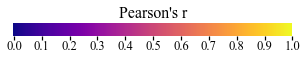

In [17]:
plot_color_gradients("plasma", dpi=60, header="Pearson's r")

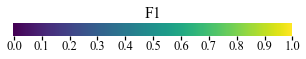

In [18]:
plot_color_gradients("viridis", dpi=60, header="F1")

### 1.3 F1 heatmaps
The F1 heatmaps were created for the hold-out test set, the genomes of _A. thaliana_ and _O. sativa_. Peak calling on predictions and the experimental data was performed with [MACS3](https://github.com/macs3-project/MACS). The sample bam files of the experimental data per species and dataset were merged. Then peaks were called on the merged bam files with MACS3’s “callpeak” command. The parameters for calling ATAC-seq peaks were the BAMPE format, a q-value of 0.01, keeping all duplicates, using the background lambda as local lambda (“no-lambda”) and the ungapped genome size of the species’ genome assembly as mappable genome size. For ChIP-seq peak calling two parameters, broad and a broad cutoff of 0.1, were added. The chosen q-value was the default 0.05. MACS3’s “bdgpeakcall” was used to call peaks on the test species predictions in bedGraph file format. The parameters for peak calling were the same MACS3’s “callpeak” determined for the experimental data, i.e. for paired end reads the minimum length and maximum gap are set to the predicted fragment size. The cutoff value, threshold of the minimum read coverage to call a peak, was estimated by plotting the average read coverage of predictions around the TSS.   
    
**Table: Peak calling parameters.** The selected parameters of MACS3’s “bdgpeakcall” for each test species and dataset are listed.    
    
|Test species          |Dataset           |Minimum length|Maximum gap|Cutoff|
|:---------------------|:-----------------|:-------------|:----------|:-----|
|_Arabidopsis thaliana_|ATAC-seq          |149           |149        |5     |
|_Arabidopsis thaliana_|ChIP-seq (H3K4me3)|201           |201        |15    |
|_Oryza sativa_        |ATAC-seq          |73            |73         |15    |
|_Oryza sativa_        |ChIP-seq (H3K4me3)|142           |142        |10    |

In [19]:
def load_specific_f1(species, dataset, path, models, idx):
    array = []
    for i, model in enumerate(models):
        f1 = np.loadtxt(f"{path}/{species}_{dataset}_{model}_auPRC.txt", usecols=2)[idx]  # cutoff
        array.append(f1)
    return np.array(array)

In [20]:
def plot_heatmap(data, cmap, xlabels, ylabels, figsize=(14, 10), dpi=100, yaxis=True, square=True, fsize=19):
    fig, ax = plt.subplots(1, sharex=True, figsize=figsize, dpi=dpi)
    cmap = copy.copy(mpl.colormaps[cmap])
    cmap.set_bad(color="silver")  # NaN values are represented by siver/grey
    im = sns.heatmap(ax=ax, data=data, cmap=cmap, vmin=0., vmax=1., square=square, annot=True, fmt=".4f",
                     cbar_kws={"ticks":np.arange(0., 1.1, 0.1), "pad": 0.05, "aspect":20, "shrink": 0.7},
                     annot_kws={'family':"Times New Roman", 'fontsize': fsize-2})
    ax.set_xticks(np.arange(len(xlabels))+0.5, labels=xlabels, fontname="Times New Roman")
    ax.tick_params(axis="x", labelrotation=90, labelsize=fsize)
    
    ax.set_yticks(np.arange(len(ylabels))+0.5, labels=ylabels, fontname="Times New Roman", style="italic")
    ax.tick_params(axis="y", labelrotation=0, labelsize=fsize)
    
    ax.yaxis.tick_left()
    ax.xaxis.tick_bottom()
    
    # cbar
    cbar = im.collections[0].colorbar
    cbar.ax.set_ylabel("F1",rotation=-90, va="bottom", size=fsize+1, fontname="Times New Roman")
    cbar.ax.tick_params(labelsize=fsize-2, color="black", direction="out", length=5., pad=0.5, width=1.5)
    for l in cbar.ax.yaxis.get_ticklabels():
        l.set_family("Times New Roman")

    plt.setp(ax.spines.values(), color=None)
    plt.show()

In [21]:
species = "Athaliana"
dataset = "atacseq"
path = "../paper/auPRC"
models = ["unet", "hybrid", "bihybrid", "bihybrid_02", "bihybrid_031", "bihybrid_032",
          "bihybrid_04", "combined", "combined_02"]
atac_data1 = load_specific_f1(species, dataset, path, models, 4) # cutoff of 5
species = "Osativa"
atac_data2 = load_specific_f1(species, dataset, path, models, 3) # cutoff of 15
atac_data = np.stack([atac_data1[:], atac_data2[:]])
print(atac_data.shape)

(2, 9)


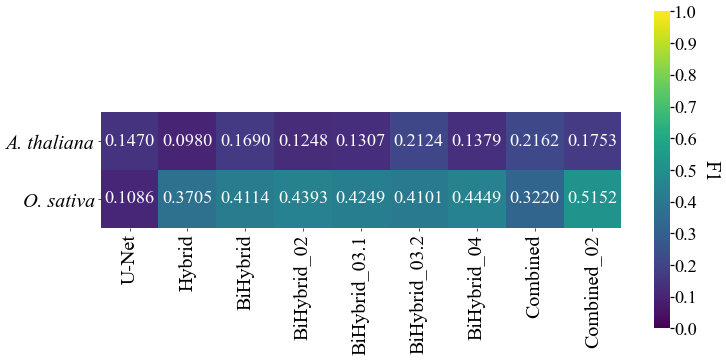

In [22]:
plot_heatmap(atac_data, "viridis",
             ["U-Net", "Hybrid", "BiHybrid", "BiHybrid_02", "BiHybrid_03.1", "BiHybrid_03.2",
              "BiHybrid_04", "Combined", "Combined_02"], ["A. thaliana", "O. sativa"],
             figsize=(14, 10), dpi=60, yaxis=True, square=True, fsize=24)

In [23]:
species = "Athaliana"
dataset = "h3k4me3"
path = "../paper/auPRC"
models = ["bihybrid_05", "combined", "combined_02"]
chip_data1 = load_specific_f1(species, dataset, path, models, 3) # cutoff of 15
species = "Osativa"
chip_data2 = load_specific_f1(species, dataset, path, models, 2) # cutoff of 10
chip_data = np.stack([chip_data1[:], chip_data2[:]])
print(chip_data.shape)
n = np.array([[np.nan, np.nan, np.nan, np.nan, np.nan, np.nan], [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]])
print(n.shape)
chip_data = np.concatenate([chip_data, n], axis=1)
print(chip_data.shape)

(2, 3)
(2, 6)
(2, 9)


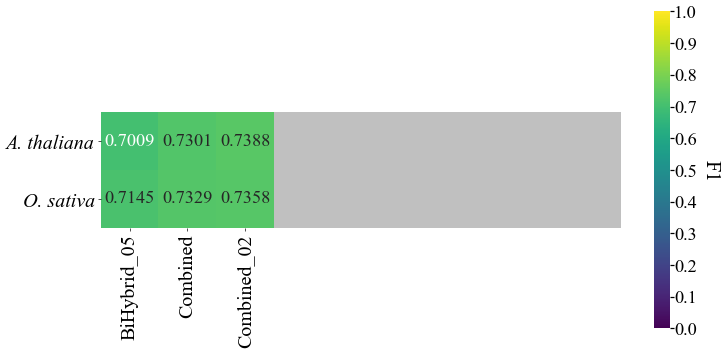

In [24]:
plot_heatmap(chip_data, "viridis",
             ["BiHybrid_05", "Combined", "Combined_02"], ["A. thaliana", "O. sativa"],
             figsize=(14, 10), dpi=60, yaxis=True, square=True, fsize=24)

## 2. Precision-recall curves
For peak calling on the ATAC-seq predictions of _A. thaliana_, cutoffs in the range of 1 to 25 with a step of 1 and for _O. sativa_ cutoffs in the range of 5 to 200 with a step of 5 and including a cutoff of 1 at the start were chosen. For the ChIP-seq predictions of both species, cutoffs in the range of 5 to 100 with a step of 5 and including a cutoff of 1 at the start were chosen.

In [25]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [26]:
def plot_auprc(matrix, labels, baselines, cmap="turbo_r", fsize=17, figsize=(9.5, 9), dpi=100, legend_loc=None):
    colormap = mpl.colormaps.get_cmap(cmap)
    colors = colormap(np.linspace(0, 1, len(labels)))
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    for i in range(len(matrix)):
        precision = matrix[i][0]
        recall = matrix[i][1]
        auprc = auc(recall, precision)
        ax.plot(recall, precision, label=f"{labels[i]} (AUPRC={round(auprc, 3)})", c=colors[i], lw=2.2, marker='o')
        #for x, y, text in zip(recall, precision, marker_labels):
        #    plt.text(x, y, text)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        
    for line, line_value in baselines.items():
        color = "darkgrey" if line == "baseline 1" else "dimgrey"
        ax.axhline(line_value, c=color, linestyle="dashed")
        if line == "baseline 1":
            position = line_value - 0.035
        else:
            position = line_value + 0.01
        ax.text(0.05, position, line, c=color, size=fsize, fontname="Times New Roman")

    for l in ax.get_yticklabels():
        l.set_family("Times New Roman")

    for l in ax.get_xticklabels():
        l.set_family("Times New Roman")
        
    for i, label in enumerate(ax.get_xticklabels()):
        if i==0:
            label.set_horizontalalignment('left') # right most x tick label
        elif i==5:
            label.set_horizontalalignment('right')
    
    for i, label in enumerate(ax.get_yticklabels()):
        if i==0:
            label.set_verticalalignment('baseline') # right most x tick label
        elif i==5:
            label.set_verticalalignment('center_baseline')

    ax.tick_params(axis="x", labelsize=fsize+2)
    ax.tick_params(axis='y', labelsize=fsize+2)
    ax.set_ylabel("Precision", size=fsize+3, fontname="Times New Roman")  # , labelpad=ylabel_pad
    ax.set_xlabel("Recall", size=fsize+3, fontname="Times New Roman")
    if legend_loc is None:
        plt.legend(prop={'family':"Times New Roman", 'size':fsize},  labelspacing=0.25, handlelength=1,
                   handletextpad=0.2, borderpad=0.2, borderaxespad=0.15, framealpha=0.45)
    else:
        plt.legend(prop={'family':"Times New Roman", 'size':fsize},  labelspacing=0.25,
                   handlelength=1, handletextpad=0.2, borderpad=0.2, borderaxespad=0.15, framealpha=0.45, loc=legend_loc)
    plt.show()

### 2.1 PRCs per model

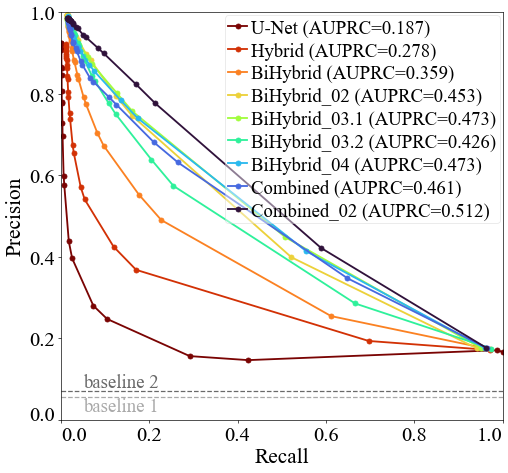

In [28]:
species = "Athaliana"
dataset = "atacseq"
path = "../paper/auPRC"
models = ["unet", "hybrid", "bihybrid", "bihybrid_02", "bihybrid_031", "bihybrid_032",
          "bihybrid_04", "combined", "combined_02"]  # 1 to 25
matrix = []
for i, model in enumerate(models):
    precision = np.loadtxt(f"{path}/{species}_{dataset}_{model}_auPRC.txt", usecols=3)
    recall = np.loadtxt(f"{path}/{species}_{dataset}_{model}_auPRC.txt", usecols=4)
    matrix.append(np.stack([precision, recall]))
    
labels = ["U-Net", "Hybrid", "BiHybrid", "BiHybrid_02", "BiHybrid_03.1", "BiHybrid_03.2",
          "BiHybrid_04", "Combined", "Combined_02"]
baselines = {"baseline 1": 0.0564, "baseline 2": 0.0699}
plot_auprc(matrix, labels, baselines, dpi=60, fsize=22.5)

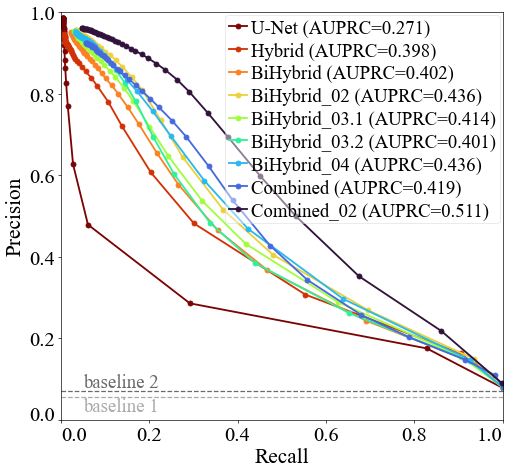

In [29]:
species = "Osativa"
dataset = "atacseq"
path = "../paper/auPRC"
models = ["unet", "hybrid", "bihybrid", "bihybrid_02", "bihybrid_031", "bihybrid_032",
          "bihybrid_04", "combined", "combined_02"] # 1, 5 to 200 (step of 5)
matrix = []
for i, model in enumerate(models):
    precision = np.loadtxt(f"{path}/{species}_{dataset}_{model}_auPRC.txt", usecols=3)
    recall = np.loadtxt(f"{path}/{species}_{dataset}_{model}_auPRC.txt", usecols=4)
    matrix.append(np.stack([precision, recall]))
    
labels = ["U-Net", "Hybrid", "BiHybrid", "BiHybrid_02", "BiHybrid_03.1", "BiHybrid_03.2",
          "BiHybrid_04", "Combined", "Combined_02"]
baselines = {"baseline 1": 0.0564, "baseline 2": 0.0699}
plot_auprc(matrix, labels, baselines, dpi=60, fsize=22.5)

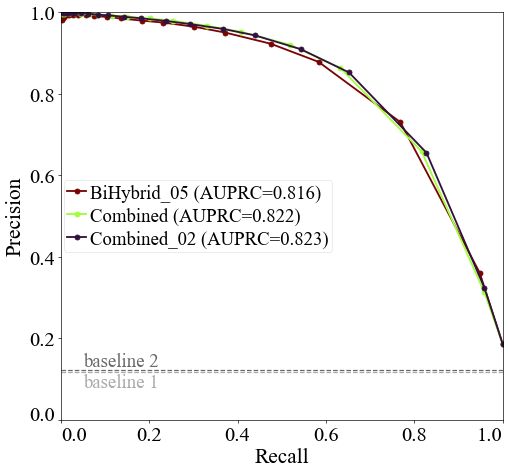

In [30]:
species = "Athaliana"
dataset = "h3k4me3"
path = "../paper/auPRC"
models = ["bihybrid_05", "combined", "combined_02"]  # 1, 5 to 100 (step of 5)
matrix = []
for model in models:
    precision = np.loadtxt(f"{path}/{species}_{dataset}_{model}_auPRC.txt", usecols=3)
    recall = np.loadtxt(f"{path}/{species}_{dataset}_{model}_auPRC.txt", usecols=4)
    matrix.append(np.stack([precision, recall]))
    
labels = ["BiHybrid_05", "Combined", "Combined_02"]
baselines = {"baseline 1": 0.1162, "baseline 2": 0.1227}
plot_auprc(matrix, labels, baselines, dpi=60, fsize=22.5)

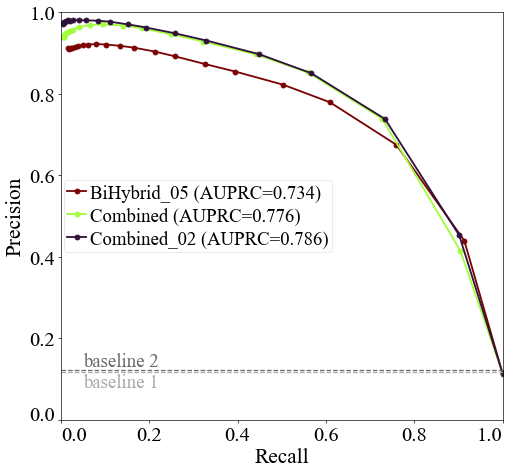

In [31]:
species = "Osativa"
dataset = "h3k4me3"
path = "../paper/auPRC"
models = ["bihybrid_05", "combined", "combined_02"]  # 1, 5 to 100 (step of 5)
matrix = []
for model in models:
    precision = np.loadtxt(f"{path}/{species}_{dataset}_{model}_auPRC.txt", usecols=3)
    recall = np.loadtxt(f"{path}/{species}_{dataset}_{model}_auPRC.txt", usecols=4)
    matrix.append(np.stack([precision, recall]))
    
labels = ["BiHybrid_05", "Combined", "Combined_02"]
baselines = {"baseline 1": 0.1162, "baseline 2": 0.1227}
plot_auprc(matrix, labels, baselines, dpi=60, fsize=22.5)

### 2.2 PRCs for smoothed predictions

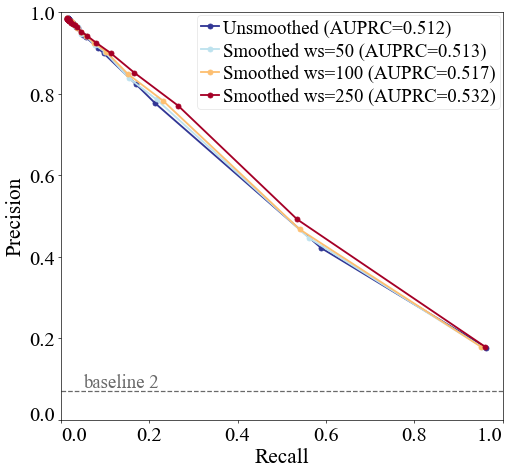

In [32]:
species = "Athaliana"
dataset = "atacseq"
path = "../paper/auPRC"
model = "combined_02"
windows=["", "_ws=50", "_ws=100", "_ws=250"]  # 1 to 25
matrix = []
for ws in windows:
    precision = np.loadtxt(f"{path}/{species}_{dataset}_{model}{ws}_auPRC.txt", usecols=3)
    recall = np.loadtxt(f"{path}/{species}_{dataset}_{model}{ws}_auPRC.txt", usecols=4)
    matrix.append(np.stack([precision, recall]))
    
labels = ["Unsmoothed", "Smoothed ws=50", "Smoothed ws=100", "Smoothed ws=250"]
baselines = {"baseline 2": 0.0699}
plot_auprc(matrix, labels, baselines, cmap="RdYlBu_r", dpi=60, fsize=22.5, legend_loc="upper right")

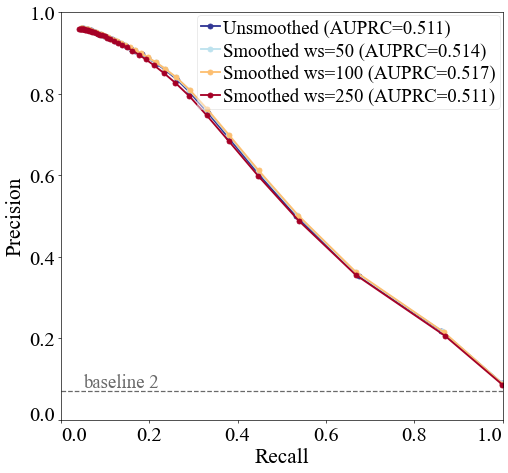

In [33]:
species = "Osativa"
dataset = "atacseq"
path = "../paper/auPRC"
model = "combined_02"
windows=["", "_ws=50", "_ws=100", "_ws=250"]  # 1, 5 to 200 (step of 5)
matrix = []
for ws in windows:
    precision = np.loadtxt(f"{path}/{species}_{dataset}_{model}{ws}_auPRC.txt", usecols=3)
    recall = np.loadtxt(f"{path}/{species}_{dataset}_{model}{ws}_auPRC.txt", usecols=4)
    matrix.append(np.stack([precision, recall]))
    
labels = ["Unsmoothed", "Smoothed ws=50", "Smoothed ws=100", "Smoothed ws=250"]
baselines = {"baseline 2": 0.0699}
plot_auprc(matrix, labels, baselines, cmap="RdYlBu_r", dpi=60, fsize=22.5, legend_loc="upper right")  # 1 to 30

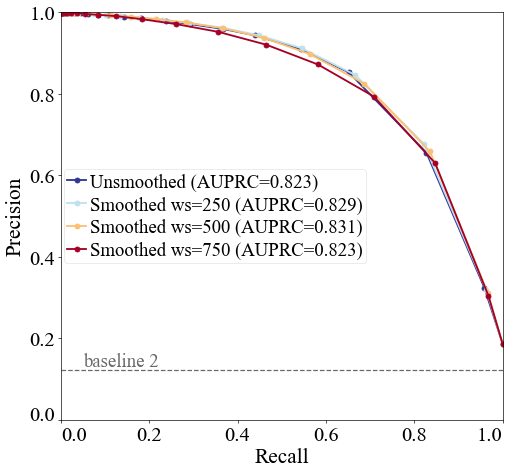

In [34]:
species = "Athaliana"
dataset = "h3k4me3"
path = "../paper/auPRC"
model = "combined_02"
windows=["", "_ws=250", "_ws=500", "_ws=750"]  # 1, 5 to 100 (step of 5)
matrix = []
for ws in windows:
    precision = np.loadtxt(f"{path}/{species}_{dataset}_{model}{ws}_auPRC.txt", usecols=3)
    recall = np.loadtxt(f"{path}/{species}_{dataset}_{model}{ws}_auPRC.txt", usecols=4)
    matrix.append(np.stack([precision, recall]))
    
labels = ["Unsmoothed", "Smoothed ws=250", "Smoothed ws=500", "Smoothed ws=750"]
baselines = {"baseline 2": 0.1227}
plot_auprc(matrix, labels, baselines, cmap="RdYlBu_r", dpi=60, fsize=22.5)

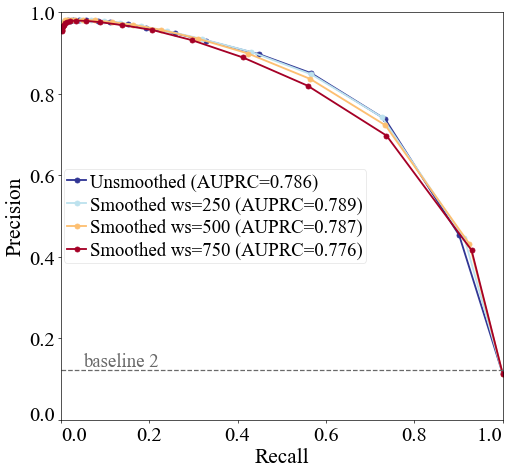

In [35]:
species = "Osativa"
dataset = "h3k4me3"
path = "../paper/auPRC"
model = "combined_02"
windows=["", "_ws=250", "_ws=500", "_ws=750"]  # 1, 5 to 100 (step of 5)
matrix = []
for ws in windows:
    precision = np.loadtxt(f"{path}/{species}_{dataset}_{model}{ws}_auPRC.txt", usecols=3)
    recall = np.loadtxt(f"{path}/{species}_{dataset}_{model}{ws}_auPRC.txt", usecols=4)
    matrix.append(np.stack([precision, recall]))
    
labels = ["Unsmoothed", "Smoothed ws=250", "Smoothed ws=500", "Smoothed ws=750"]
baselines = {"baseline 2": 0.1227}
plot_auprc(matrix, labels, baselines, cmap="RdYlBu_r", dpi=60, fsize=22.5)